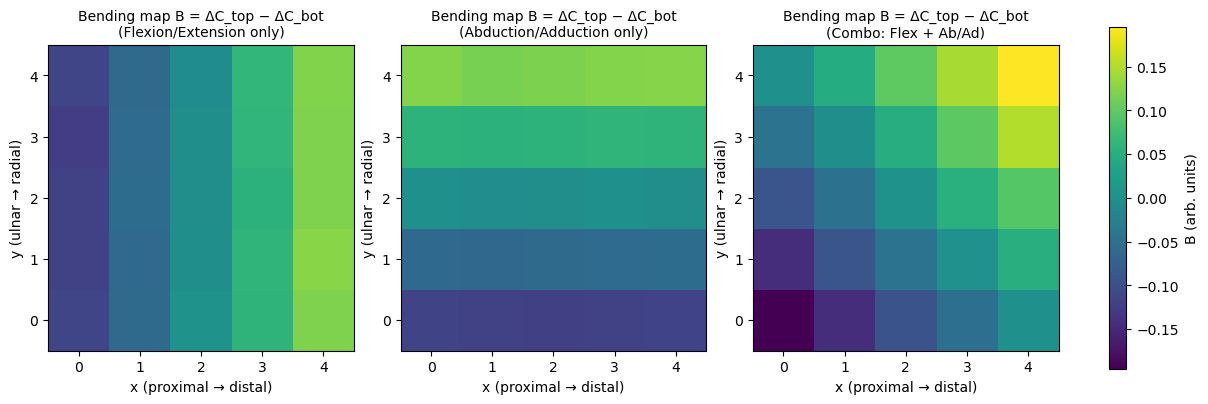

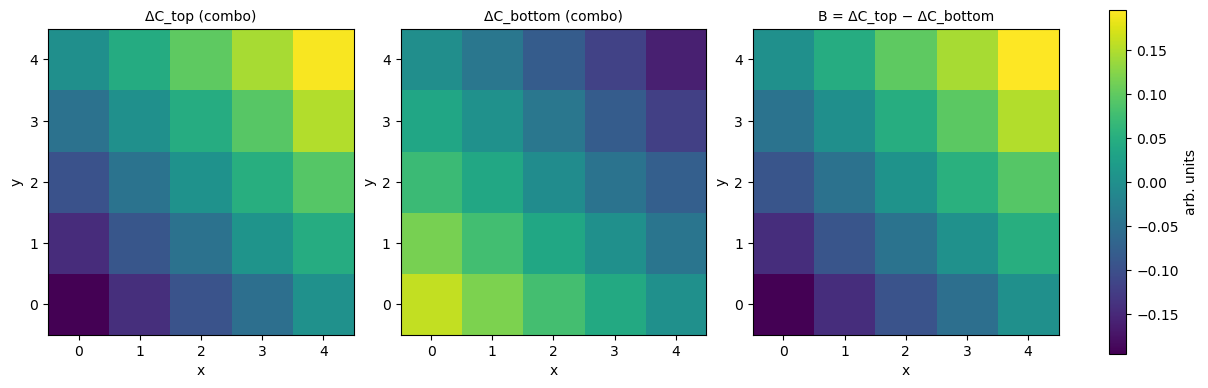

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Settings ---
np.random.seed(7)
nx, ny = 5, 5                        # grid size (x = proximal->distal, y = ulnar->radial)
k = 0.06                              # "bending sensitivity" scaling (arbitrary units)
common_stretch = 0.01                 # small common-mode stretch term (same sign on both planes)
noise_std = 0.002                     # measurement noise

# Coordinate grids
x = np.linspace(-1, 1, nx)            # proximal (-1) to distal (+1)
y = np.linspace(-1, 1, ny)            # ulnar (-1) to radial (+1)
X, Y = np.meshgrid(x, y)              # shape (ny, nx) for plotting with imshow

def simulate_two_plane(flex_gain=1.0, abd_gain=1.0):
    """
    Synthetic top/bottom capacitance changes for a two-plane grid.
    - flexion/extension produces an x-gradient curvature pattern (varies along X)
    - ab/ad produces a y-gradient curvature pattern (varies along Y)
    """
    # "Curvature-like" fields (mode shapes)
    flex_field = flex_gain * X
    abd_field  = abd_gain  * Y
    curvature_field = flex_field + abd_field

    # Small common-mode component that affects both planes similarly (overall stretch/pressure)
    common = common_stretch * (0.5*X + 0.5*Y)

    # Top/bottom changes: opposite sign for bending component, same sign for common-mode
    dC_top = (+k * curvature_field) + common + np.random.normal(0, noise_std, size=curvature_field.shape)
    dC_bot = (-k * curvature_field) + common + np.random.normal(0, noise_std, size=curvature_field.shape)

    # Differential bending-only map
    B = dC_top - dC_bot
    return dC_top, dC_bot, B

# --- Three cases ---
# 1) Flexion only
dCt_flex, dCb_flex, B_flex = simulate_two_plane(flex_gain=1.0, abd_gain=0.0)
# 2) Ab/ad only
dCt_abd,  dCb_abd,  B_abd  = simulate_two_plane(flex_gain=0.0, abd_gain=1.0)
# 3) Combo (both)
dCt_mix,  dCb_mix,  B_mix  = simulate_two_plane(flex_gain=0.8, abd_gain=0.8)

# --- Plot: Bending maps (top-bottom difference) as heatmaps ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

maps = [B_flex, B_abd, B_mix]
titles = [
    "Bending map B = ΔC_top − ΔC_bot\n(Flexion/Extension only)",
    "Bending map B = ΔC_top − ΔC_bot\n(Abduction/Adduction only)",
    "Bending map B = ΔC_top − ΔC_bot\n(Combo: Flex + Ab/Ad)"
]

# Shared color limits for easy comparison
vmax = max(np.abs(m).max() for m in maps)
vmin = -vmax

for ax, B, title in zip(axes, maps, titles):
    im = ax.imshow(B, origin="lower", vmin=vmin, vmax=vmax, aspect="equal")
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("x (proximal → distal)")
    ax.set_ylabel("y (ulnar → radial)")
    ax.set_xticks(range(nx))
    ax.set_yticks(range(ny))

cbar = fig.colorbar(im, ax=axes, shrink=0.9)
cbar.set_label("B (arb. units)")
plt.show()

# --- Optional: show top vs bottom planes for the combo case ---
fig2, ax2 = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

vmax2 = max(np.abs(dCt_mix).max(), np.abs(dCb_mix).max())
vmin2 = -vmax2

ax2[0].imshow(dCt_mix, origin="lower", vmin=vmin2, vmax=vmax2, aspect="equal")
ax2[0].set_title("ΔC_top (combo)", fontsize=10)
ax2[0].set_xlabel("x"); ax2[0].set_ylabel("y")

ax2[1].imshow(dCb_mix, origin="lower", vmin=vmin2, vmax=vmax2, aspect="equal")
ax2[1].set_title("ΔC_bottom (combo)", fontsize=10)
ax2[1].set_xlabel("x"); ax2[1].set_ylabel("y")

im2 = ax2[2].imshow(B_mix, origin="lower", vmin=vmin, vmax=vmax, aspect="equal")
ax2[2].set_title("B = ΔC_top − ΔC_bottom", fontsize=10)
ax2[2].set_xlabel("x"); ax2[2].set_ylabel("y")

cbar2 = fig2.colorbar(im2, ax=ax2, shrink=0.9)
cbar2.set_label("arb. units")
plt.show()
